# Task 1 : Set up colab gpu runtime environment

In [1]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
%%capture
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

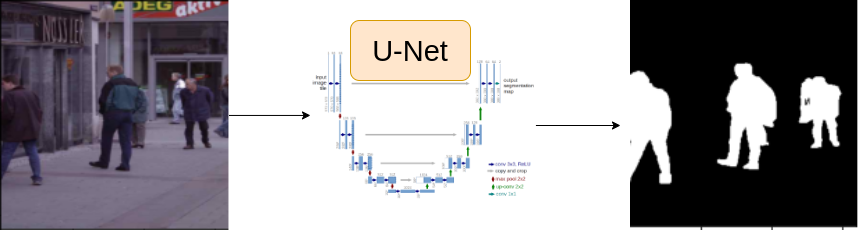

# Essential Library Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import torch
from torch.utils.data import Dataset

import torch.nn as nn
from torch.utils.data import DataLoader


import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import cv2
import albumentations as A

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

#Custom Module
import helper

In [5]:
torch.manual_seed(3407)

# Task : 2 Setup Configurations

In [6]:

#Defining Required Configs
Data_Dir = "/content/"
CSV_File = "/content/Human-Segmentation-Dataset-master/train.csv"

device = "cuda"
epochs = 25
lr = 0.003
batch_size = 16
Image_Size = 320

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [7]:
df = pd.read_csv(CSV_File)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[6]
image = row.images
mask = row.masks
image = cv2.imread(image)
mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)/ 255.0

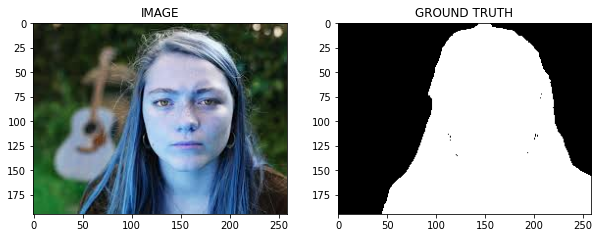

In [9]:
#BGR Color
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
row = df.iloc[6]
image = row.images
mask = row.masks
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)/ 255.0

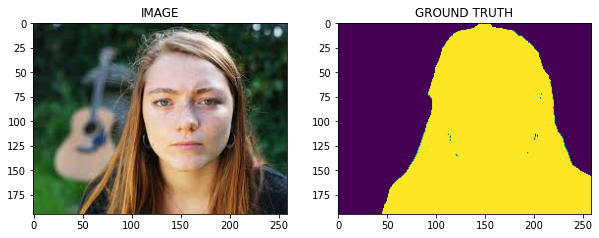

In [11]:
#RGB Color Mode
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [12]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((232, 2), (58, 2))

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [13]:


def get_train_augs():
  return A.Compose([
      A.Resize(Image_Size,Image_Size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      #A.RandomCrop(),
                    ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(Image_Size,Image_Size)
                    ],is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations


  def __len__(self):

    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)

      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask



In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


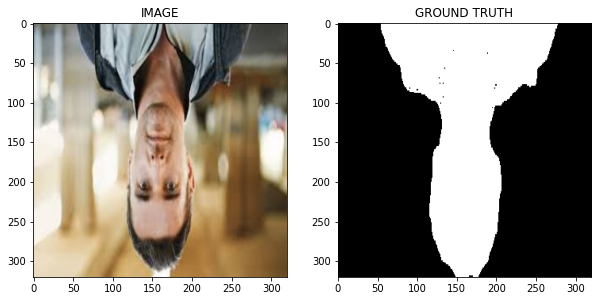

In [17]:

idx = 32
images, masks = trainset[idx]
helper.show_image(images,masks)

# Task 5 : Load dataset into batches

In [18]:

trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [19]:
len(trainloader)

15

In [20]:
len(validloader)

4

In [21]:
#Read One Sample of Image from Dataset
batch = next(iter(trainloader))

In [22]:
len(batch)


2

In [23]:
image, mask = batch

In [24]:
print(image.shape)

torch.Size([16, 3, 320, 320])


In [25]:
print(mask.shape)

torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [26]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
    super(SegmentationModel,self).__init__()
    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes= 1,
        activation = None,
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1+loss2

    return logits




In [27]:
model = SegmentationModel()
model.to(device) 

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [28]:
def train_func(data_loader, model, optimizer):

  model.train()

  total_loss = 0.0
  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()

    logits, loss = model(images, masks)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss/len(data_loader)

  return avg_loss

In [29]:
def val_func(data_loader, model):

  model.eval()

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)
  

      total_loss += loss.item()

    avg_loss = total_loss/len(data_loader)

  return avg_loss

# Task 8 : Train Model

In [30]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)


In [31]:
best_valid_loss = np.Infinity

for i in range(epochs):
  train_loss = train_func(trainloader, model, optimizer)
  valid_loss = val_func(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-model.pt')
    print("Model Saved")

    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss is : {train_loss}, Valid Loss is : {valid_loss}" )

100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Model Saved
Epoch: 1 Train Loss is : 0.7637151698271434, Valid Loss is : 0.5830228105187416


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 2 Train Loss is : 0.3869514266649882, Valid Loss is : 0.697721391916275


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Model Saved
Epoch: 3 Train Loss is : 0.2929201384385427, Valid Loss is : 0.5256539881229401


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Model Saved
Epoch: 4 Train Loss is : 0.31090012689431507, Valid Loss is : 0.29775508865714073


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Model Saved
Epoch: 5 Train Loss is : 0.2637753039598465, Valid Loss is : 0.2610343061387539


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Model Saved
Epoch: 6 Train Loss is : 0.23808207114537558, Valid Loss is : 0.23292668163776398


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 7 Train Loss is : 0.22251168588797252, Valid Loss is : 0.23531390354037285


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Model Saved
Epoch: 8 Train Loss is : 0.17215444793303808, Valid Loss is : 0.21571047231554985


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch: 9 Train Loss is : 0.17788042724132538, Valid Loss is : 0.224691491574049


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 10 Train Loss is : 0.1626974234978358, Valid Loss is : 0.29730376973748207


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch: 11 Train Loss is : 0.21510766645272572, Valid Loss is : 0.28396451845765114


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 12 Train Loss is : 0.2544368296861649, Valid Loss is : 0.24589753895998


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 13 Train Loss is : 0.22635333140691122, Valid Loss is : 0.2277584671974182


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 14 Train Loss is : 0.17961691121260326, Valid Loss is : 0.2172589749097824


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Model Saved
Epoch: 15 Train Loss is : 0.197343547642231, Valid Loss is : 0.2135029062628746


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Model Saved
Epoch: 16 Train Loss is : 0.17758200367291768, Valid Loss is : 0.17799700982868671


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 17 Train Loss is : 0.15384518951177598, Valid Loss is : 0.22038958221673965


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 18 Train Loss is : 0.13368089546759923, Valid Loss is : 0.18780124559998512


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 19 Train Loss is : 0.12041712055603664, Valid Loss is : 0.20259016379714012


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 20 Train Loss is : 0.10550510386625926, Valid Loss is : 0.2001017164438963


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 21 Train Loss is : 0.10390257289012274, Valid Loss is : 0.18093939311802387


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 22 Train Loss is : 0.11057949215173721, Valid Loss is : 0.22482526674866676


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 23 Train Loss is : 0.1009649395942688, Valid Loss is : 0.19822937808930874


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Model Saved
Epoch: 24 Train Loss is : 0.0965337152282397, Valid Loss is : 0.15759656764566898


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

Epoch: 25 Train Loss is : 0.08725088040033976, Valid Loss is : 0.18138455227017403


# Task 9 : Inference

In [32]:
idx = 20

model.load_state_dict(torch.load('/content/best-model.pt'))

image, mask = validset[idx]
#image, mask = image.to(device), mask.to(device)
model.to(device)
#model.eval()
logits_mask = model(image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5) * 1.0

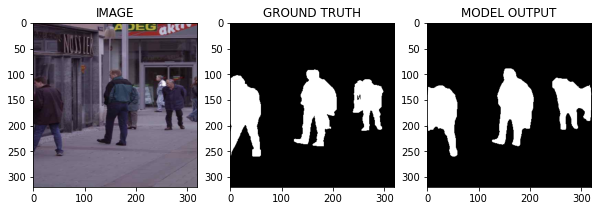

In [33]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))